Authors: Hofmarcher

Date: 20-03-2023

---

This file is part of the "Deep Reinforcement Learning" lecture material. The following copyright statement applies to all code within this file.

Copyright statement:
This material, no matter whether in ed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in ed or in electronic form, requires explicit prior acceptance of the authors.

## Enable GPU Acceleration

---
Before you start exploring this notebook make sure that GPU support is enabled.
To enable the GPU backend for your notebook, go to **Edit** → **Notebook Settings** and set **Hardware accelerator** to **GPU**.

---


# Imports

Install Gymnasium and dependencies to render the environments

In [ ]:
!apt-get update
!apt-get install -y swig python3-numpy python3-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python3-opengl libboost-all-dev libsdl2-dev
!pip install gymnasium==0.29.0 gymnasium[box2d] pyvirtualdisplay imageio-ffmpeg moviepy==1.0.3
!pip install onnx onnx2pytorch==0.4.1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,083 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,118 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main 

In [ ]:
!nvidia-smi

Wed May 15 08:57:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
%matplotlib inline

# Auxiliary Python imports
import os
import math
import io
import base64
import random
import shutil
from time import time, strftime
from glob import glob
from tqdm import tqdm
import numpy as np

# Pytorch
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import onnx
from onnx2pytorch import ConvertModel

# Environment import and set logger level to display error only
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
gymlogger.set_level(gym.logger.ERROR)

# Plotting and notebook imports
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output
from IPython import display

# Select device for training

By default we train on GPU if one is available, otherwise we fall back to the CPU.
If you want to always use the CPU change accordingly.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
("Device: " + str(device))

'Device: cuda'

# Setup Google Drive mount to store your results

In [ ]:
use_google_drive = True
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


# Download Dataset and Expert model

In [ ]:
# Download training and validation datasets
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download' -O expert.onnx
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download' -O train.zip
!wget --no-check-certificate 'https://cloud.ml.jku.at/s/3DxHLiqxTddepp8/download' -O val.zip

# Unzip datasets
!unzip -q -o train.zip
!unzip -q -o val.zip

--2024-05-15 17:29:54--  https://cloud.ml.jku.at/s/citYJKPgmAGrHGy/download
Resolving cloud.ml.jku.at (cloud.ml.jku.at)... 140.78.90.41
Connecting to cloud.ml.jku.at (cloud.ml.jku.at)|140.78.90.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6747975 (6.4M) [application/octet-stream]
Saving to: ‘expert.onnx’

expert.onnx         100%[===================>]   6.43M  3.54MB/s    in 1.8s    

2024-05-15 17:29:57 (3.54 MB/s) - ‘expert.onnx’ saved [6747975/6747975]

--2024-05-15 17:29:57--  https://cloud.ml.jku.at/s/yJ2ZsfqTos3Jn9y/download
Resolving cloud.ml.jku.at (cloud.ml.jku.at)... 140.78.90.41
Connecting to cloud.ml.jku.at (cloud.ml.jku.at)|140.78.90.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85373838 (81M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]  81.42M  13.9MB/s    in 7.3s    

2024-05-15 17:30:05 (11.1 MB/s) - ‘train.zip’ saved [85373838/85373838]

--2024-05-15 17:30:05--  

# Auxiliary Methods

The following cell contains classes and functions to provide some functionality for logging, plotting and exporting your model in the format required by the submission server.
You are free to use your own logging framework if you wish (such as tensorboard or Weights & Biases).
The logger is a very simple implementation of a CSV-file based logger.
Additionally it creates a folder for each run with subfolders for model files, logs and videos.

In [ ]:
class Logger():
    def __init__(self, logdir, params=None):
        self.basepath = os.path.join(logdir, strftime("%Y-%m-%dT%H-%M-%S"))
        os.makedirs(self.basepath, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        if params is not None and os.path.exists(params):
            shutil.copyfile(params, os.path.join(self.basepath, "params.pkl"))
        self.log_dict = {}
        self.dump_idx = {}

    @property
    def param_file(self):
        return os.path.join(self.basepath, "params.pkl")

    @property
    def onnx_file(self):
        return os.path.join(self.basepath, "model.onnx")

    @property
    def video_dir(self):
        return os.path.join(self.basepath, "videos")

    @property
    def log_dir(self):
        return os.path.join(self.basepath, "logs")

    def log(self, name, value):
        if name not in self.log_dict:
            self.log_dict[name] = []
            self.dump_idx[name] = -1
        self.log_dict[name].append((len(self.log_dict[name]), time(), value))

    def get_values(self, name):
        if name in self.log_dict:
            return [x[2] for x in self.log_dict[name]]
        return None

    def dump(self):
        for name, rows in self.log_dict.items():
            with open(os.path.join(self.log_dir, name + ".log"), "a") as f:
                for i, row in enumerate(rows):
                    if i > self.dump_idx[name]:
                        f.write(",".join([str(x) for x in row]) + "\n")
                        self.dump_idx[name] = i


def plot_metrics(logger):
    train_loss  = logger.get_values("training_loss")
    train_entropy  = logger.get_values("training_entropy")
    val_loss = logger.get_values("validation_loss")
    val_acc = logger.get_values("validation_accuracy")

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131, label="train")
    ax2 = fig.add_subplot(131, label="val",frame_on=False)
    ax4 = fig.add_subplot(132, label="entropy")
    ax3 = fig.add_subplot(133, label="acc")

    ax1.plot(train_loss, color="C0")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Update (Training)", color="C0")
    ax1.xaxis.grid(False)
    ax1.set_ylim((0,4))

    ax2.plot(val_loss, color="C1")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel('Epoch (Validation)', color="C1")
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.grid(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim((0,4))

    ax4.plot(train_entropy, color="C3")
    ax4.set_xlabel('Update (Training)', color="black")
    ax4.set_ylabel("Entropy", color="C3")
    ax4.tick_params(axis='x', colors="black")
    ax4.tick_params(axis='y', colors="black")
    ax4.xaxis.grid(False)

    ax3.plot(val_acc, color="C2")
    ax3.set_xlabel("Epoch (Validation)", color="black")
    ax3.set_ylabel("Accuracy", color="C2")
    ax3.tick_params(axis='x', colors="black")
    ax3.tick_params(axis='y', colors="black")
    ax3.xaxis.grid(False)
    ax3.set_ylim((0,1))

    fig.tight_layout(pad=2.0)
    plt.show()

"""
Utility functions to enable video recording of gym environment and displaying it
"""
def show_video(video_dir):
    mp4list = glob(f'{video_dir}/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        ("Could not find video")

def save_as_onnx(torch_model, sample_input, model_path):
    torch.onnx.export(torch_model,             # model being run
                    sample_input,              # model input (or a tuple for multiple inputs)
                    f=model_path,              # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=17,          # the ONNX version to export the model to - see https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    )

# Dataset

Use this dataset class to load the provided demonstrations. Furthermore, this dataset has functionality to add new samples to the dataset which you will need for implementing the DAgger algorithm.

In [ ]:
class DemonstrationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted(glob(f"{data_dir}/*.npz"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        state = data["state"][np.newaxis, ...].astype(np.float32)
        action = data["action"]
        return state / 255.0, action.item()

    def append(self, states, actions):
        offset = len(self) + 1
        for i in range(len(states)):
            filename = f"{self.data_dir}/{offset+i:06}.npz"
            np.savez_compressed(filename, state=states[i], action=actions[i].astype(np.int32))
            self.files.append(filename)

# Inspect data

It is always a good idea to take a look at the data when you start working with a new dataset. Feel free to investigate the dataset further on your own.

In [ ]:
# Action Statistics
dataset = DemonstrationDataset("train")
("Number of samples: {}".format(len(dataset)));

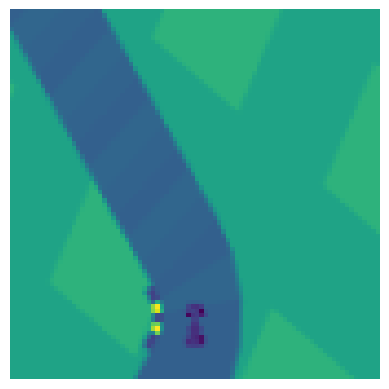

In [ ]:
# Action mapping from gymnasium.farama.org
action_mapping = {
    0: "do nothing",
    1: "steer left",
    2: "steer right",
    3: "gas",
    4: "brake"
}

# Visualize random frames
idx = np.random.randint(len(dataset))
state, action = dataset[idx]
# store a single frame as we need it later for exporting an ONNX model (it needs a sample of the input for the export)
sample_state = torch.Tensor(state).unsqueeze(0).to(device)
# Display the sample
(f"Action: {action_mapping[action]}")
plt.axis("off")
plt.imshow(state[0]);

In [ ]:
# release memory"
del dataset

# Define Policy Network

You need to design a neural network architecture that is capable of mapping a state to an action.
The input is a single image with the following properties:
- Resolution of 84x84 pixels
- Grayscale (meaning a single channel as opposed to three channels of an RGB image)
- The values of each pixel should be between 0 and 1

The output of the network should be one unit per possible action, as our environment has 5 actions that results in 5 output units.
Your network must implement the forward function in order to be compatible with the evaluation script.

## Policy Network using CNN

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_units_out):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=5)
        self.relu = nn.ReLU6()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(-1, 7*7*64)
        x = self.relu(self.fc1(x))
        x = self.fc3(self.fc2(x))
        return x

# Train behavioral cloning policy

Now that you have a Dataset and a network you need to train your network.
With behavioral cloning we want to imitate the behavior of the agent that produced the demonstration dataset as close as possible.
This is basically supervised learning, where you want to minimize the loss of your network on the training and validation sets.

Some tips as to what you need to implement:
- choose the appropriate loss function (think on which kind of problem you are solving)
- choose an optimizer and its hyper-parameters
- optional: use a learning-rate scheduler
- don't forget to evaluate your network on the validation set
- store your model and training progress often so you don't loose progress if your program crashes

In case you use the provided Logger:
- `logger.log("training_loss", <loss-value>)` to log a particular value
- `logger.dump()` to write the current logs to a log file (e.g. after every episode)
- `logger.log_dir`, `logger.param_file`, `logger.onnx_file`, `logger.video_dir` point to files or directories you can use to save files
- you might want to specify your google drive folder as a logdir in order to automatically sync your results
- if you log the metrics specified in the `plot_metrics` function you can use it to visualize your training progress (or take it as a template to plot your own metrics)

## Training with CNN policy notwork

Trainable Parameters: 1711141

Training:


epoch: 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.8675716519355774 0.8357193470001221 0.6897118091583252
Saved Model with Accuarcy: 0.6897118091583252
epoch: 1
0.7710374593734741 0.8062699437141418 0.6990957260131836
Saved Model with Accuarcy: 0.6990957260131836
epoch: 2
0.7664689421653748 0.7848722338676453 0.7049267888069153
Saved Model with Accuarcy: 0.7049267888069153
epoch: 3
0.7647703289985657 0.7792288661003113 0.7078828811645508
Saved Model with Accuarcy: 0.7078828811645508
epoch: 4
0.7645887136459351 0.7781127691268921 0.7111433744430542
Saved Model with Accuarcy: 0.7111433744430542
epoch: 5
0.7629515528678894 0.7970869541168213 0.7024557590484619
epoch: 6
0.764301598072052 0.7754291892051697 0.7088391184806824
Saved Model with Accuarcy: 0.7088391184806824
epoch: 7
0.7601005434989929 0.7855395078659058 0.7070260047912598
epoch: 8
0.7601819634437561 0.7783852815628052 0.7089202404022217
epoch: 9
0.7600017189979553 0.7784703373908997 0.7082868218421936
epoch: 10
0.7595125436782837 0.7798320055007935 0.7102054953575134
epoch: 

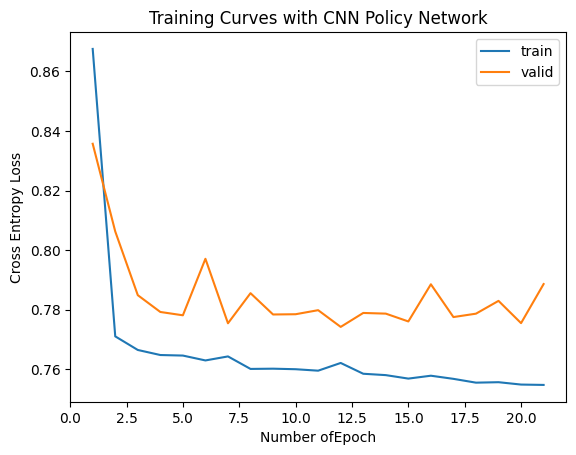

In [ ]:
# choose the batchsize for training
batch_size = 256

# Datasets
train_set = DemonstrationDataset("train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
# You can also choose to use a different logging framework such as tensorboard (not recommended on Colab) or Weights & Biases (highly recommended)
logger = Logger("logdir")
#print("Saving state to {}".format(logger.basepath))

# Network
model = PolicyNetwork(n_units_out=5)
# model = PolicyNetworkMLP(n_units_out=5)
model = model.to(device)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: {}".format(num_trainable_params))

######################
### YOUR CODE HERE ###
######################
# Implement your training and evaluation loop
# feel free to define your own functions for training and evaluation


epochs=21
cce_loss = nn.CrossEntropyLoss(reduction="sum")
optimiser =  torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
early_stopping_counter,cur_stopping_counter,best_val_loss,best_val_acc=10,0,np.inf,0

@torch.no_grad()
def evaluate(network: nn.Module, data: torch.utils.data.DataLoader, loss: nn.Module):
    network.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network.to(device)
    errors=[]
    accs=[]
    for batch in data:
        inputs,labels=batch
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=network(inputs)
        error=loss(outputs,labels).item()
        errors.append(error)
        accs.append((torch.argmax(outputs,1)==labels).sum()/labels.size(0))
    return torch.mean(torch.tensor(errors)),torch.mean(torch.tensor(accs))


@torch.enable_grad()
def update(network: nn.Module, data: torch.utils.data.DataLoader, loss: nn.Module, opt: torch.optim.Optimizer):
    network.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network=network.to(device)

    errors=[]
    for i,batch in enumerate(data):
        opt.zero_grad()
        inputs,labels=batch
        labels=labels.to(device)
        inputs=inputs.to(device)
        output=network(inputs)
        l=loss(output,labels)
        errors.append(l.item())
        l.backward()
        opt.step()

    return torch.mean(torch.tensor(errors))

def training_plot(train_errs,valid_errs):
    plt.title("Training Curves with CNN Policy Network")
    plt.xlabel("Number ofEpoch")
    plt.ylabel("Cross Entropy Loss")
    plt.plot(range(1, len(train_errs) + 1), train_errs, label="train")
    plt.plot(range(1, len(valid_errs) + 1), valid_errs, label="valid")
    plt.legend()
    plt.show()

print("")



if not os.path.exists("best_model.pt"):
    print("Training:\n\n")

    train_errors,validation_errors=[],[]

    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        train_loss=(update(model,train_loader,cce_loss,optimiser)/batch_size).item()
        validation_params=(evaluate(model,val_loader,cce_loss))
        val_loss, val_acc = (validation_params[0]/batch_size).item(), validation_params[1].item()

        print(train_loss, val_loss, val_acc)
        if val_loss < best_val_loss:
            torch.save(model, f"best_model.pt")
            cur_stopping_counter=0
            best_val_loss = val_loss
            best_val_acc = val_acc
            print(f"Saved Model with Accuarcy: {best_val_acc}")
        else:
            cur_stopping_counter+=1


        train_errors.append(train_loss)
        validation_errors.append(val_loss)

        #if cur_stopping_counter==early_stopping_counter:
            #print(f"Early Stopped after {epoch} Epochs")
            #print("Best model has a validation loss of: {}")
            #break


    print("End Training:\n\n")

    training_plot(train_errors,validation_errors)
    # If you want to export your model as an ONNX file use the following code as template
    # If you use the provided logger you can use this directly
    save_as_onnx(model, sample_state, logger.onnx_file)
    model=torch.load(f"best_model.pt")
else:
    model = torch.load("best_model_0712.pt")
    validation_params=(evaluate(model,val_loader,cce_loss))
    val_acc =  validation_params[1].item()
    print(f"Accuarcy of Model: {val_acc}")
    save_as_onnx(model, sample_state, logger.onnx_file)
    print("Loaded Model")

## Policy Network using MLP


In [ ]:
class PolicyNetworkMLP(nn.Module):
    def __init__(self, n_units_out):
        super(PolicyNetworkMLP, self).__init__()
        self.fc1 = nn.Linear(84*84, 512)  # Flatten 84x84 image into a vector
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_units_out)  # Output layer with one unit per action
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 84*84)  # Flatten the image to a vector
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training with MLP Policy Network

Training Curves with MLP Policy Network
Epoch 0: Train Loss = 0.8650590181350708, Validation Loss = 0.8139646649360657, Validation Accuracy = 0.6944565773010254
Epoch 1: Train Loss = 0.7825213074684143, Validation Loss = 0.7796814441680908, Validation Accuracy = 0.7104166150093079
Epoch 2: Train Loss = 0.7773613929748535, Validation Loss = 0.8002150058746338, Validation Accuracy = 0.7051562070846558
Epoch 3: Train Loss = 0.7763291001319885, Validation Loss = 0.790749192237854, Validation Accuracy = 0.7082990407943726
Epoch 4: Train Loss = 0.7764405608177185, Validation Loss = 0.7992104291915894, Validation Accuracy = 0.7004865407943726
Epoch 5: Train Loss = 0.7741339206695557, Validation Loss = 0.7953072786331177, Validation Accuracy = 0.7020823359489441
Epoch 6: Train Loss = 0.7706799507141113, Validation Loss = 0.7825185656547546, Validation Accuracy = 0.7041816115379333
Epoch 7: Train Loss = 0.7701650261878967, Validation Loss = 0.7781651020050049, Validation Accuracy = 0.7103049159

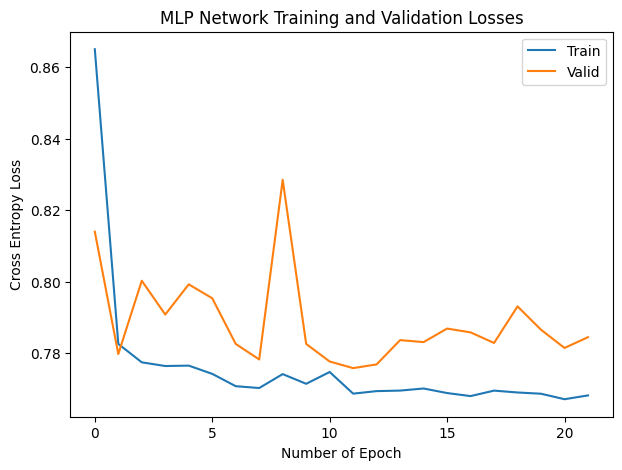

In [ ]:
# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the dataset loaders
batch_size = 256
train_set = DemonstrationDataset("train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

# Define logger (assuming Logger class is defined somewhere)
logger = Logger("logdir")

def train_and_evaluate(model, epochs=22):
    model = model.to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    cce_loss = nn.CrossEntropyLoss(reduction="sum")

    @torch.no_grad()
    def evaluate(network):
        network.eval()
        errors, accs = [], []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = network(inputs)
            error = cce_loss(outputs, labels).item()
            errors.append(error)
            accs.append((torch.argmax(outputs, 1) == labels).sum() / labels.size(0))
        return torch.mean(torch.tensor(errors)), torch.mean(torch.tensor(accs))

    @torch.enable_grad()
    def update(network):
        network.train()
        errors = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimiser.zero_grad()
            outputs = network(inputs)
            loss = cce_loss(outputs, labels)
            errors.append(loss.item())
            loss.backward()
            optimiser.step()
        return torch.mean(torch.tensor(errors))

    train_errors, validation_errors = [], []
    for epoch in range(epochs):
        train_loss = update(model) / batch_size
        val_loss, val_acc = evaluate(model)
        val_loss, val_acc = val_loss / batch_size, val_acc.item()

        train_errors.append(train_loss.item())
        validation_errors.append(val_loss.item())
        print(f"Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}, Validation Accuracy = {val_acc}")

    return train_errors, validation_errors

# Define the networks
mlp_model = PolicyNetworkMLP(n_units_out=5)

# Train and plot for MLP
print("Training Curves with MLP Policy Network")
mlp_train_errors, mlp_validation_errors = train_and_evaluate(mlp_model)
plt.figure(figsize=(7, 5))
plt.plot(mlp_train_errors, label='Train')
plt.plot(mlp_validation_errors, label='Valid')
plt.title('MLP Network Training and Validation Losses')
plt.xlabel('Number of Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

# Evaluate the agent in the real environment

### Environment and Agent

We provide some wrappers you need in order to get the same states from the environment as in the demonstration dataset.
Additionally the `RecordState` wrapper should be very helpful in collecting new samples for the DAgger algorithm.

In [ ]:
class CropObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        gym.ObservationWrapper.__init__(self, env)
        self.shape = shape
        obs_shape = self.shape + env.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        return observation[:self.shape[0], :self.shape[1]]


class RecordState(gym.Wrapper):
    def __init__(self, env: gym.Env, reset_clean: bool = True):
        gym.Wrapper.__init__(self, env)

        assert env.render_mode is not None
        self.frame_list = []
        self.reset_clean = reset_clean

    def step(self, action, **kwargs):
        output = self.env.step(action, **kwargs)
        self.frame_list.append(output[0])
        return output

    def reset(self, *args, **kwargs):
        result = self.env.reset(*args, **kwargs)

        if self.reset_clean:
            self.frame_list = []
        self.frame_list.append(result[0])

        return result

    def render(self):
        frames = self.frame_list
        self.frame_list = []
        return frames


class Agent():
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def select_action(self, state):
        with torch.no_grad():
            state = torch.Tensor(state).unsqueeze(0).to(device) / 255.0 # rescale
            logits = self.model(state)
            if type(logits) is tuple:
                logits = logits[0]
            probs = Categorical(logits=logits)
            return probs.sample().cpu().numpy()[0]


def make_env(seed, capture_video=True):
    env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        env = gym.wrappers.RecordVideo(env, logger.video_dir)

    env = CropObservation(env, (84, 96))
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = RecordState(env, reset_clean=True)
    env = gym.wrappers.FrameStack(env, 4)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def run_episode(agent, show_progress=True, capture_video=True, seed=None):
    env = make_env(seed=seed, capture_video=capture_video)
    state, _ = env.reset()
    score = 0
    done = False
    if show_progress:
        progress = tqdm(desc="Score: 0")

    while not done:
        action = agent.select_action(state[-1][np.newaxis, ...])
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        done = terminated or truncated
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))
    env.close()

    if show_progress:
        progress.close()
    if capture_video:
        show_video(logger.video_dir)

    return score

## Evaluate behavioral cloning agent

Let's see how the agent is doing in the real environment

In [ ]:
train_policy = Agent(model, device)
score = run_episode(train_policy, show_progress=True, capture_video=True);
(f"Score: {score:.2f}")

Score: 884.77: : 999it [00:27, 36.38it/s]

Moviepy - Building video /content/logdir/2024-05-15T17-31-13/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/logdir/2024-05-15T17-31-13/videos/rl-video-episode-0.mp4




t: 100%|█████████▉| 1000/1001 [00:02<00:00, 410.53it/s, now=None]
Score: 884.67: : 1000it [00:30, 33.17it/s]

Moviepy - Done !
Moviepy - video ready /content/logdir/2024-05-15T17-31-13/videos/rl-video-episode-0.mp4


'Score: 884.67'

Since we often have high variance when evaluating RL agents we should evaluate the agent multiple times to get a better feeling for its performance.

In [ ]:
train_policy = Agent(model, device)
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    ("Score: %d" % scores[-1])
("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Episode: 100%|██████████| 10/10 [01:56<00:00, 11.69s/it]


'Mean Score: 632.46 (Std: 177.95)'

# DAGGER

Now we can implement DAgger, you have downloaded a relatively well trained model you can use as an expert for this purpose.

Load expert model that is provided as ONNX file.

## Load the expert

In [ ]:
# Load expert
expert_model = ConvertModel(onnx.load("expert.onnx"))
expert_model = expert_model.to(device)
# Freeze expert weights
for p in expert_model.parameters():
    p.requires_grad = False

expert_policy = Agent(expert_model, device)

/usr/local/lib/python3.10/dist-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


In [ ]:
# model = PolicyNetworkMLP(n_units_out=5)
model = model.to(device)
train_policy = Agent(model, device)

Next, you have to implement the DAgger algorithm (see slides for details). This function implements the core idea of DAgger:


1. Choose the policy with probability beta
2. Sample T-step trajectories using this policy
3. Label the gathered states with the expert

The aggregation and training part are already implemented.

## DAGGER Algorithm Code

In [ ]:
# inner loop of DAgger
def dagger(env, train_policy, expert_policy, dataset, beta=1., num_steps=1000):

    ######################
    ### YOUR CODE HERE ###
    ######################

    number_episodes_for_train = 0
    number_episodes_for_expert = 0
    for t in range(num_steps):
        policy = np.random.choice([train_policy, expert_policy], p=[1 - beta, beta])
        state, info = env.reset()
        done_or_truncated = False

        if policy == train_policy:
            number_episodes_for_train += 1
            print("current policy is train policy")
        else:
            number_episodes_for_expert += 1
            print("current policy is expert policy")


        while not done_or_truncated:
            if policy == train_policy:
                input_state = np.expand_dims(state[-1], 0)

            else:
                input_state = state

            action = policy.select_action(input_state)
            next_state, reward, done, truncated,_ = env.step(action)

            if policy == train_policy:
                expert_action = expert_policy.select_action(state)
                dataset.append(np.squeeze([np.expand_dims(state[-1], 0)], axis=0), [expert_action])
                # print("train_policy",np.squeeze([np.expand_dims(state[-1], 0)], axis=0).shape)
            else:
                # print("expert_policy",np.squeeze([np.expand_dims(state[-1], 0)], axis=0).shape)
                dataset.append(np.squeeze([np.expand_dims(state[-1], 0)], axis=0), [action])

            state = next_state
            if done or truncated:
                done_or_truncated = True
        beta *= 0.95  # Reduce beta to decrease the chance of selecting expert policy
    print("added {} train episodes and {} expert episodes".format(number_episodes_for_train, number_episodes_for_expert))
    return dataset

Put everything together now.
1. Create new samples using the DAgger algorithm
2. Continue training your agent
3. Export your fully trained agent as an ONNX file

## DAGGER Training Code

Saving state to /content/logdir_dagger/2024-05-15T09-36-07
Trainable Parameters: 1711141
No checkpoint found at specified path, starting training from scratch
current policy is expert policy
current policy is expert policy
current policy is expert policy
current policy is train policy
current policy is expert policy
current policy is expert policy
current policy is train policy
current policy is expert policy
current policy is expert policy
current policy is train policy
current policy is train policy
current policy is expert policy
current policy is train policy
current policy is train policy
current policy is expert policy
current policy is expert policy
current policy is expert policy
current policy is train policy
current policy is train policy
current policy is expert policy
added 8 train episodes and 12 expert episodes
Epoch: 0, Batch: 0, Training Loss: 1.652296
Epoch: 0, Batch: 10, Training Loss: 1.239484
Epoch: 0, Batch: 20, Training Loss: 1.188192
Epoch: 0, Batch: 30, Training

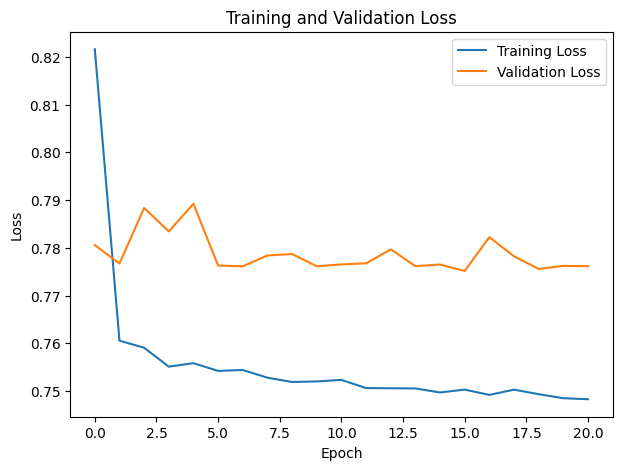

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def compute_entropy(logits):
    probabilities = F.softmax(logits, dim=1)
    log_probabilities = F.log_softmax(logits, dim=1)
    entropy = -(probabilities * log_probabilities).sum(dim=1).mean()  # Mean entropy per batch
    return entropy.item()

def compute_accuracy(logits, targets):
    _, predicted_labels = logits.max(dim=1)
    correct = (predicted_labels == targets).float()  # Correct predictions
    accuracy = correct.sum() / len(correct)  # Accuracy per batch
    return accuracy.item()

######################
### YOUR CODE HERE ###
######################
# Implement your training and evaluation loop
# feel free to define your own functions for training and evaluation

# choose the batch size for training
batch_size = 256

# Datasets
train_set = DemonstrationDataset("train")
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)
val_set = DemonstrationDataset("val")
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False, pin_memory=True)

# Specify the google drive mount here if you want to store logs and weights there (and set it up earlier)
# You can also choose to use a different logging framework such as tensorboard (not recommended on Colab) or Weights & Biases (highly recommended)
logger = Logger("/content/logdir_dagger")
print("Saving state to {}".format(logger.basepath))
env = make_env(seed=42, capture_video=False)

# Network
model = PolicyNetwork(n_units_out=5)
model = model.to(device)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable Parameters: {}".format(num_trainable_params))

# Load from a saved checkpoint
checkpoint_path = "/content/logdir/2024-04-13T21-13-43/params.pkl"
if os.path.exists(checkpoint_path):
    # Load the model state dictionary
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Loaded checkpoint from {checkpoint_path}")
else:
    print("No checkpoint found at specified path, starting training from scratch")

num_epochs = 21
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

# we will try another optimizers
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_policy = Agent(model, device)
beta = 1.0
train_set = dagger(env, train_policy, expert_policy, train_set, beta, num_steps=20)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Convert collected data to DataLoader
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=False, pin_memory=True)

    model.train()
    train_loss = 0.0
    train_entropy = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        logger.log("training_loss", loss.item())

        entropy = compute_entropy(output)
        train_entropy += entropy
        logger.log("training_entropy", entropy)

        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Training Loss: {loss.item():.6f}")

    # Average training loss for the epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch}, Average Training Loss: {train_loss:.6f}")

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()

            accuracy = compute_accuracy(output, target)
            val_accuracy += accuracy
            logger.log("validation_accuracy", accuracy)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy /= len(val_loader)
    print(f"Epoch: {epoch}, Validation Loss: {val_loss:.6f}")
    logger.log("validation_loss", val_loss)
    logger.dump()

    # Save model checkpoint
    checkpoint_path = logger.param_file.format(epoch)
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

    beta *= 0.95

# Plotting training and validation loss after training
plt.figure(figsize=(7, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# If you want to export your model as an ONNX file use the following code as template
# If you use the provided logger you can use this directly
save_as_onnx(model, sample_state, logger.onnx_file)
env.close()


In [ ]:
n_eval_episodes = 10
scores = []
for i in tqdm(range(n_eval_episodes), desc="Episode"):
    scores.append(run_episode(train_policy, show_progress=False, capture_video=False))
    ("Score: %d" % scores[-1])
("Mean Score: %.2f (Std: %.2f)" %(np.mean(scores), np.std(scores)))

Episode: 100%|██████████| 10/10 [01:54<00:00, 11.41s/it]


'Mean Score: 674.72 (Std: 264.07)'